In [1]:
import state_utils

from numba import jit,njit 
import state_utils

state_utils.set_cohort("Poyet")
state_utils.set_host("am")
state_utils.set_midas_db_type("standard")

import pandas as pd
import numpy as np
import time
from scipy.stats import gamma
import config
import slm_utils
from scipy.stats import chisquare
from parse_midas_data import parse_good_species_list
import sys

import matplotlib.pyplot as plt

In [145]:
## calculates the chi-squared test statistic for the goodness of fit test
def calc_chisq(obs_data,dates_diff,train_num):
    
    ## fit the SLM on the first train_num observations
    params = slm_utils.fit_SLM_params(obs_data,n=train_num)

    ## initialize SLM 
    S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1.0/100)

    ## form quin_bins number of bins, expect to have 5 (= 4 + 1) observations in each bin, per recommendations re: chisquare test
    ## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
    quin_bins = len(obs_data)//4
    
    bin_list = []
    
    ## get bin of initial value w/r/t stationary distribution
    init_bin = int(np.digitize(obs_data.iloc[train_num],S.afd.ppf(np.linspace(0,100,quin_bins + 2)/100)[1:])) - 1
    bin_list.append(init_bin)
    
    ## now get bins of all subsequent timepoints 
    ## essentially, build an empirical probability distribution for abundance at time t + delta_t given abundance at t
    ## then, figure out which quintile bin of this empirical distribution the actual observation lies in
    for i in range(train_num,len(obs_data) - 1):
        
        T = dates_diff[i+1]
        num_iters = int(1.0*T/(1.0*S.delta_t))

        init_val = obs_data.iloc[i]
        num_reps = 1000
        S.set_init_val(obs_data.iloc[i])
        S.run_sim(num_iters,num_reps,record_steps=False)

        bin_list.append(np.digitize(obs_data.iloc[i+1],np.percentile(S.x_i,np.linspace(0,100,quin_bins))))
    
    ## calculate chisquare test statistic relative to uniform expectation
    return chisquare(np.unique(bin_list,return_counts=True)[1])[1]  


In [146]:
strain_df

,SRR9224357,SRR9224359c,SRR9224362,SRR9224245,SRR9224364,SRR9224363c,SRR9224365,SRR9224525,SRR9224526,SRR9224523c,...,SRR9224103,SRR9224108,SRR9224107,SRR9224261,SRR9224319,SRR9224198,SRR9224199,SRR9224204,SRR9224205,SRR9224202
Phascolarctobacterium_sp_59817_A,NaN,NaN,NaN,NaN,NaN,0.010803,NaN,0.023785,NaN,0.015467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017244
Barnesiella_intestinihominis_62208_A,NaN,NaN,NaN,NaN,NaN,0.013125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016053,NaN
Ruminococcus_bicirculans_59300_A,NaN,0.025341,0.059925,NaN,NaN,0.016109,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bacteroides_uniformis_57318_A,0.097250,0.106400,0.092371,0.179700,0.140319,0.144183,0.128073,0.116682,0.141561,0.069706,...,0.162765,0.216812,0.238023,0.069904,0.184115,0.187216,0.143129,0.182858,0.149643,0.185502
Ruminococcus_bromii_62047_A,NaN,0.021448,NaN,NaN,NaN,NaN,NaN,0.158282,0.044124,0.073153,...,NaN,NaN,NaN,NaN,0.034901,0.030704,0.035059,NaN,NaN,0.022633
Faecalibacterium_prausnitzii_57453_A,NaN,0.020836,NaN,NaN,NaN,0.011354,NaN,NaN,NaN,0.017594,...,NaN,NaN,NaN,NaN,0.017046,0.024570,NaN,NaN,NaN,NaN
Parabacteroides_merdae_56972_A,NaN,NaN,NaN,NaN,0.079141,0.087541,0.238293,0.097206,0.046594,0.061427,...,NaN,0.041102,0.036063,NaN,0.021560,NaN,NaN,0.060152,0.056929,0.036106
Bacteroides_stercoris_56735_A,NaN,0.015619,NaN,NaN,0.030357,0.039915,0.025947,0.024356,0.038729,0.051250,...,NaN,NaN,NaN,NaN,0.025400,NaN,0.024139,0.035670,0.031252,0.025288
Eubacterium_rectale_56927_A,0.017037,0.005719,NaN,NaN,NaN,0.007644,NaN,0.005587,0.014266,0.018588,...,NaN,NaN,NaN,0.037593,0.016587,0.015229,0.030234,0.005451,0.014809,0.008561
Eubacterium_rectale_56927_B,0.170371,0.037176,NaN,NaN,NaN,0.059624,NaN,0.039109,0.110561,0.137550,...,NaN,NaN,NaN,0.247040,0.120255,0.091373,0.195148,0.024529,0.114771,0.073623


In [212]:
data_dir=config.data_directory

strain_df = pd.read_csv("strains_%s.csv"%config.host,index_col=0)
species="Ruminococcus_bicirculans_59300"
strain="Ruminococcus_bicirculans_59300_A"

obs_data = strain_df.loc[strain]

In [213]:
good_samples = pd.read_csv("%s/snps/%s/snps_summary.txt" % (data_dir,species),index_col=0,sep="\t").index

obs_data = strain_df.loc[strain]

obs_data = obs_data[good_samples]
obs_data = obs_data[obs_data.notna()]

In [214]:
strain_dates = config.dates.loc[obs_data.index].sort_values()
obs_data = obs_data.loc[strain_dates.index]
dates_diff = strain_dates.diff()
train_num = len(obs_data)//3

In [215]:
m=[calc_chisq(obs_data,dates_diff,train_num) for _ in range(10)]

In [216]:
m

[0.31337427753639774,
 0.3045864272527498,
 0.2675991471353167,
 0.2675991471353167,
 0.43417534401782215,
 0.17808107329076456,
 0.20678083985998702,
 0.10783024873533556,
 0.27437671299934663,
 0.2675991471353167]

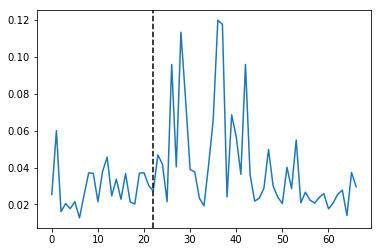

In [217]:
plt.plot(obs_data.values);
plt.axvline(train_num,ls="--",color="k")

In [10]:
data_dir=config.data_directory

strain_df = pd.read_csv("strains_%s.csv"%config.host,index_col=0)
strain = strain_df.index[-1]

species = strain[:-2]
chisq_dic = {}

good_samples = pd.read_csv("%s/snps/%s/snps_summary.txt" % (data_dir,species),index_col=0,sep="\t").index
sys.stderr.write("Processing %s \n" % species)
for strain in strain_df.index:
    
    species = strain[:-2]
    
    good_samples = pd.read_csv("%s/snps/%s/snps_summary.txt" % (data_dir,species),index_col=0,sep="\t").index

    obs_data = strain_df.loc[strain]

    obs_data = obs_data[good_samples]
    obs_data = obs_data[obs_data.notna()]
    if len(obs_data) >= 25:
        strain_dates = config.dates.loc[obs_data.index].sort_values()

        ## be sure observed data is in correct chronological order                
        obs_data = obs_data.loc[strain_dates.index]
        strain_dates_diff = strain_dates.diff()
        train_num = len(obs_data)//3
        #chisq_dic[strain] = calc_chisq(obs_data,strain_dates_diff,train_num)
        chisq_dic[strain] = np.mean([calc_chisq(obs_data,strain_dates_diff,train_num) for _ in range(1)])
        print(strain,chisq_dic[strain])

(pd.Series(chisq_dic) > .05).mean()

Processing Alistipes_putredinis_61533 


('Bacteroides_clarus_62282_A', 0.013697578731732944)
('Bacteroides_massiliensis_44749_A', 5.6703821449567095e-09)
('Paraprevotella_clara_33712_A', 0.04840246583234738)
('Bacteroides_xylanisolvens_57185_A', 2.4818204127008266e-06)
('Ruminococcus_bromii_62047_A', 0.7285603394663751)
('Sutterella_wadsworthensis_56828_A', 0.0008318767848785334)
('Sutterella_wadsworthensis_56828_B', 0.6683792145532862)
('Bacteroides_uniformis_57318_A', 0.13963337813708845)
('Bacteroides_uniformis_57318_B', 9.958026081633539e-05)
('Eubacterium_rectale_56927_A', 0.3354379434312973)
('Eubacterium_rectale_56927_B', 0.8114018780087344)
('Bacteroides_vulgatus_57955_A', 9.034168571050217e-06)
('Bacteroides_vulgatus_57955_B', 0.010925967043841488)
('Bacteroides_vulgatus_57955_C', 0.2286164869193094)
('Barnesiella_intestinihominis_62208_A', 0.13588822540043327)
('Alistipes_putredinis_61533_A', 0.3554257195403813)


0.5

In [ ]:
#pd.Series(chisq_dic).to_csv("/u/home/r/rwolff/strain_stability_revisions/strainstability/analysis/chisq/Poyet/ae_strain_chisq_test_cross.txt")

In [ ]:
plt.hist(chisq_dic['Alistipes_putredinis_61533_A'],bins=np.logspace(-4,0,20))
plt.xlim([1e-5,1]);
plt.semilogx()

In [ ]:
plt.plot(strain_dates.values,obs_data.values)
plt.axvline(strain_dates.values[train_num])

In [ ]:
train_num

In [ ]:
np.median(chisq_dic['Bacteroides_vulgatus_57955_C'])

In [ ]:
data_dir=config.data_directory

strain_df = pd.read_csv("strains_%s.csv"%config.host,index_col=0)
strain = strain_df.index[-1]

species = strain[:-2]
chisq_dic = {}

good_samples = pd.read_csv("%s/snps/%s/snps_summary.txt" % (data_dir,species),index_col=0,sep="\t").index
sys.stderr.write("Processing %s \n" % species)
obs_data = strain_df.loc[strain]

obs_data = obs_data[good_samples]
obs_data = obs_data[obs_data.notna()]
if len(obs_data) > 25:
    strain_dates = config.dates.loc[obs_data.index].sort_values()

    ## be sure observed data is in correct chronological order                
    obs_data = obs_data.loc[strain_dates.index]
    strain_dates_diff = strain_dates.diff()
    train_num = len(obs_data)//3
    #chisq_dic[strain] = calc_chisq(obs_data,strain_dates_diff,train_num)
    chisq_dic[strain] = [calc_chisq(obs_data,strain_dates_diff,train_num) for _ in range(1)]
    print(np.mean(chisq_dic[strain]))